# Two qubit gates modeled with two three-level transmons coupled via resonator

https://journals.aps.org/pra/pdf/10.1103/PhysRevA.101.052308
The two transmon model used here is presented in Eq. 2.12 of  PHYSICAL REVIEW A 101, 052308 (2020).

In [2]:
import numpy as np
import qiskit.pulse as pulse
from matplotlib import pyplot as plt
from qiskit_dynamics.pulse import InstructionToSignals
from qiskit.quantum_info.operators import Operator
from qiskit_dynamics import Solver, Signal
from matplotlib import pyplot as plt
from qiskit.quantum_info.states import Statevector
from scipy.optimize import minimize, minimize_scalar
from scipy.linalg import expm
import sympy as sym
import jax
jax.config.update("jax_enable_x64", True)

# tell JAX we are using CPU
jax.config.update('jax_platform_name', 'cpu')

import jax.numpy as jnp
from jax import jit, value_and_grad

In [3]:
#Plot code
from mpl_toolkits.axes_grid1 import AxesGrid
def heatmap2d(arr: np.ndarray):
    # define axes grid
    fig = plt.figure(frameon=False,figsize=(12, 8))
    fig.subplots_adjust(top=0.95)
    grid = AxesGrid(
        fig, 111, 
        nrows_ncols=(1, 2),
        axes_pad=0.5,
        cbar_mode='each',
        cbar_location='right',
        cbar_pad=0.1
    )   
    # plot 
    real_image = grid[0].imshow(np.real(arr), cmap='plasma')
    grid[0].set_title("Real Part of matrix, $\Re{(M)}$", fontsize=20)
    imag_image = grid[1].imshow(np.imag(arr), cmap='plasma')
    grid[1].set_title("Imaginary Part of matrix, $\Im{(M)}$", fontsize=20)
    cbar = grid.cbar_axes[0].colorbar(real_image)
    cbar = grid.cbar_axes[1].colorbar(imag_image)
    plt.show()

#projector code
def condense(matrix):
    projector = np.diag([1, 1, 0, 1, 1, 0, 0, 0, 0])
    mat = projector @ matrix @ projector
    # Find rows and columns that are not all zeros
    non_zero_rows = np.any(mat != 0, axis=1)
    non_zero_cols = np.any(mat != 0, axis=0)

    # Condense the matrix by selecting only the non-zero rows and columns
    condensed_matrix = mat[non_zero_rows][:, non_zero_cols]
    return condensed_matrix

In [23]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel='ibm_quantum', instance="ibm-q/open/main")
backend = service.backend("ibm_sherbrooke")

qubit_num1 = 74
qubit_num2 = 89

w1 = backend.qubit_properties(qubit_num1).frequency * 1E-9 #GHz, qubit frequency
w2 = backend.qubit_properties(qubit_num2).frequency * 1E-9

d1 = backend.qubit_properties(qubit_num1).anharmonicity * 1E-9 #GHz, anharmonicity
d2 = backend.qubit_properties(qubit_num2).anharmonicity * 1E-9 #GHz, anharmonicity

b1 = - 1 / (2 * d1) #ns, DRAG derivative strength
b2 = - 1 / (2 * d2) #ns, DRAG derivative strength

Δ12 = w1 - w2 #GHz, qubit detuning


dt = backend.dt * 1E9 #ns, AWG sample time
dur = int(backend.target["sx"][(qubit_num1,)].duration * 1E9 / dt) #dt, single gate pulse duration
σ = dur / 4 #convention that duration is 4 sigma
n = 3 #3 level system
r = 0.1 #GHz, rabi frequency 

ecr_dur = backend.target["ecr"][(89, 74)].duration * 1E9 / dt
x_dur = backend.target["x"][(74,)].duration * 1E9 / dt
rzx_dur = dur2 = int((ecr_dur - 2*x_dur)/2)
rzx_dur

944

In [29]:
ecr_dur*dt

533.3333333333333

In [28]:
x_dur*dt

56.888888888888886

In [25]:
rzx_dur*dt

209.77777777777777

In [216]:
class Transmon:
    def __init__(self, qubit_freq, anharmonicity, rabi_strength, pulse_duration, dt, compute_SX_X_gates = False):
        self.w = qubit_freq #GHz
        self.d = anharmonicity #GHz
        self.r = rabi_strength #GHz
        self.dur = pulse_duration #units of dt
        self.β = - 1 / (2 * self.d) #ns
        self.σ = self.dur / 4 #dt
        self.dt = dt #ns
        n = 3 #3 level model

        # construct the solver
        self.hamiltonian_solver = Solver(
            static_hamiltonian=Operator(Transmon.H_transmon(n, self.w, self.d)),
            hamiltonian_operators=[Operator(Transmon.H_drive(n, self.r))],
            rotating_frame=Operator(Transmon.H_transmon(n, self.w, self.d)),
            rwa_carrier_freqs=[self.w],
            #rwa_cutoff_freq=2 * self.w,
            array_library='jax',
            hamiltonian_channels=['d0'],
            channel_carrier_freqs={'d0': self.w},
            dt= self.dt
        )
        if compute_SX_X_gates: self.store_SX_X_gates()


    @classmethod
    def change_num_levels(cls, num: int):
        n = num
    
    def store_SX_X_pulses(self):
            #Store optimized SX and X pulses for given qubit parameters
            self.SX_results = minimize_scalar(self.single_transmon_objective, args=(np.pi/2), bounds=(0.,1.))
            # with pulse.build(name="SX") as self.SX_pulse:
            #     pulse.play(self.drag([self.SX_results.x.item(), self.σ, self.β, self.dur]), pulse.DriveChannel(0))
            self.SX_pulse = Transmon.drag([self.SX_results.x.item(), self.σ, self.β, self.dur])
            self.X_results = minimize_scalar(self.single_transmon_objective, args=(np.pi), bounds=(0.,1.))
            # with pulse.build(name="X") as self.X_pulse:
            #     pulse.play(self.drag([self.X_results.x.item(), self.σ, self.β, self.dur]), pulse.DriveChannel(0))
            self.X_pulse = Transmon.drag([self.X_results.x.item(), self.σ, self.β, self.dur])

    #Hamiltonian helper functions
    # Standard Nonlinear Oscillator (Duffing) Hamiltonian    
    @staticmethod
    def H_transmon(max_j, w, d):
        H = np.zeros((max_j, max_j))
        for j in range(max_j):
            H[j,j] = 2*np.pi* ( (w - d/2)*(j) + (d/2)*(j**2) - w/2)
        return H
    
    #X drive hamiltonian
    @staticmethod
    def H_drive(max_j, r):
        H = np.zeros((max_j, max_j))
        for j in range(max_j - 1):
            #λ_1 = sqrt(2)
            H[j,j+1] = np.sqrt(j+1)
            H[j+1,j] = np.sqrt(j+1)
        return 2*np.pi * (r / 2) * H


    #JAX compatible lifted gaussian pulse
    @staticmethod
    def lifted_gaussian(
        t: sym.Symbol,
        center,
        t_zero,
        sigma,
    ) -> sym.Expr:
        t_shifted = (t - center).expand()
        t_offset = (t_zero - center).expand()

        gauss = sym.exp(-((t_shifted / sigma) ** 2) / 2)
        offset = sym.exp(-((t_offset / sigma) ** 2) / 2)

        return (gauss - offset) / (1 - offset)


    #JAX compatible drag pulse
    @staticmethod
    def drag(params):
        amp, sigma, beta, duration = params
        _t, _duration, _amp, _sigma, _angle, _beta = sym.symbols("t, duration, amp, sigma, angle, beta")
        _center = _duration / 2
        envelope_expr = (_amp * sym.exp(sym.I * _angle) * Transmon.lifted_gaussian(_t, _center, _duration + 1, _sigma)
                        * (1+ 1j * _beta * (_t - _center)/(_sigma**2)))

        pulse.ScalableSymbolicPulse.disable_validation = True
        return pulse.ScalableSymbolicPulse(
                pulse_type="DRAG",
                duration= duration,
                angle=0,
                amp=amp,
                parameters={"sigma": sigma, "beta": beta},
                envelope=envelope_expr,
                constraints=sym.And(_sigma > 0, _beta > 0),
                valid_amp_conditions=sym.Abs(_amp) <= 1.0,
            )

    @staticmethod
    def ideal_RX(θ):
        return jnp.array([[np.cos(θ/2), -1j*np.sin(θ/2), 0],
                        [-1j*np.sin(θ/2), np.cos(θ/2), 0],
                        [0, 0, 1]])

    @staticmethod
    def ideal_H():
        return (1/np.sqrt(2))*np.array([[1, 1, 0],
                        [1, -1, 0],
                        [0, 0, np.sqrt(2)]])

    @staticmethod
    def fidelity(ideal_gate , U):
        return jnp.abs(jnp.trace(ideal_gate.conj().T @ U))**2 / n**2
    

    def single_transmon_objective(self, amp, θ):
        #generate rx pulse schedule  
        with pulse.build(name="RX") as r_x:
            pulse.play(Transmon.drag([amp, self.σ, self.β, self.dur]), pulse.DriveChannel(0))

        #solve dynamics
        sol = self.hamiltonian_solver.solve(t_span=[0., self.dur*self.dt], y0=jnp.eye(3, dtype=complex), 
                                        method='jax_odeint', signals=r_x, atol=1e-8, rtol=1e-8)

        u = sol.y[-1]
        return 1. - Transmon.fidelity(Transmon.ideal_RX(θ), u)


    def opt_RX(self, θ, x0=0.1634):
        opt_results = minimize_scalar(self.single_transmon_objective, args=(θ), bounds=(0.,1.))
        #Optionally, can use JAX compilation for optimization - not much faster for single variable
        #jit_grad_obj = jit(value_and_grad(single_transmon_objective))
        #opt_results = minimize(fun=jit_grad_obj, x0= x0, jac=True, method='BFGS')

        #generate rx pulse schedule  
        with pulse.build(name="RX") as r_x:
            pulse.play(self.drag([opt_results.x.item(), self.σ, self.β, self.dur]), pulse.DriveChannel(0))
        
        return opt_results, r_x
    
    def hadamard(self, x0=0.1634):
        #opt_results2 = minimize_scalar(self.single_transmon_objective, args=(np.pi), bounds=(0.,1.))
        with pulse.build(name="Hadamard") as hgate:
            pulse.shift_phase(np.pi/2, pulse.DriveChannel(0))
            pulse.play(self.drag([self.SX_results.x.item(), self.σ, self.β, self.dur]), pulse.DriveChannel(0))
            pulse.shift_phase(np.pi/2, pulse.DriveChannel(0))
            #pulse.play(drag([opt_results_.x, self.σ, self.β, self.dur]), pulse.DriveChannel(0))
        return hgate

    #initial state can be a statevector or operator
    def solve_dynamics(self, initial_state, gate_pulse, plot_pops=True, JAXmethod = False):
        #solve dynamics
        if JAXmethod == True:
            sol = self.hamiltonian_solver.solve(t_span=[0., self.dur*self.dt], method='jax_odeint',
                                            y0 = initial_state, signals=gate_pulse, atol=1e-8, rtol=1e-8)
        else:
            # construct the solver
            non_jax_solver = Solver(
                static_hamiltonian=Operator(Transmon.H_transmon(n, self.w, self.d)),
                hamiltonian_operators=[Operator(Transmon.H_drive(n, self.r))],
                rotating_frame=Operator(Transmon.H_transmon(n, self.w, self.d)),
                rwa_carrier_freqs=[self.w],
                #rwa_cutoff_freq=2 * self.w,
                #array_library='jax',
                hamiltonian_channels=['d0'],
                channel_carrier_freqs={'d0': self.w},
                dt= self.dt
            )
            sol = non_jax_solver.solve(t_span=[0., self.dur*self.dt], 
                                            y0 = initial_state, signals=gate_pulse, atol=1e-8, rtol=1e-8)
            
        if plot_pops: Transmon.plot_populations(sol, self.dur*self.dt)
        return sol
    
    #Plot code
    @staticmethod    
    def plot_populations(sol, max_t):
        pop0 = [psi.probabilities()[0] for psi in sol.y]
        pop1 = [psi.probabilities()[1] for psi in sol.y]
        pop2 = [psi.probabilities()[2] for psi in sol.y]


        fig = plt.figure(figsize=(8, 5))
        plt.plot(sol.t, pop0, lw=3, label="Population in |0>")
        plt.plot(sol.t, pop1, lw=3, label="Population in |1>")
        plt.plot(sol.t, pop2, lw=3, label="Population in |2>")
        plt.xlabel("Time (ns)")
        plt.ylabel("Population")
        plt.legend(frameon=False)
        plt.ylim([0, 1.05])
        plt.xlim([0, max_t])
        plt.grid()
        #plt.vlines(T, 0, 1.05, "k", linestyle="dashed")

In [219]:
class Transmon_System:
    def __init__(self, q1: Transmon, q2: Transmon, J, dur) -> None:
        self.q1 = q1
        self.q2 = q2
        self.J = J
        #self.Ω = Ω
        self.rzx_dur = dur
        self.dt = q1.dt
        self.H_system = Transmon_System.H_sys(q1.w, q2.w, q1.d, q2.d, J)
        self.H_d_q1 = Transmon_System.H_drive_q1(self.q1.r)
        self.H_d_q2 = Transmon_System.H_drive_q2(self.q2.r)

        dressed_energies = np.linalg.eigh(self.H_system)[0]
        #If statement ensures we have E_11 - E_10 + E_01 - E_00 because dressing the states messes up their kronecker ordering.
        #w_d1 (w_d2) is the drive frequency on the control qubit 1 (control qubit 2)
        if q1.w < q2.w:
            self.w_d1 = 0.5 * (dressed_energies[5] - dressed_energies[1] + dressed_energies[2] - dressed_energies[0]) / (2 * np.pi)
            self.w_d2 = 0.5 * (dressed_energies[5] - dressed_energies[2] + dressed_energies[1] - dressed_energies[0]) / (2 * np.pi)
        else:
            self.w_d1 = 0.5 * (dressed_energies[5] - dressed_energies[2] + dressed_energies[1] - dressed_energies[0]) / (2 * np.pi)
            self.w_d2 = 0.5 * (dressed_energies[5] - dressed_energies[1] + dressed_energies[2] - dressed_energies[0]) / (2 * np.pi)
        
        self.R1 = 2*np.pi*self.w_d1*np.array([0, 1, 2, 1, 2, 3, 2, 3, 4])
        self.R2 = 2*np.pi*self.w_d2*np.array([0, 1, 2, 1, 2, 3, 2, 3, 4])
        # construct the solvers (with/without JAX for CR Frame on each qubit, and with/without JAX for individual qubit drive frame)
        self.CR_solver1 = Solver(
            static_hamiltonian=Operator(self.H_system), hamiltonian_operators=[Operator(self.H_d_q1)],
            rotating_frame=self.R1, rwa_cutoff_freq=2 * self.w_d1, rwa_carrier_freqs= [self.w_d1],
            hamiltonian_channels=['d0'],  channel_carrier_freqs={'d0': self.w_d1},dt=self.dt
        )
        self.CR_jax_solver1 = Solver(
            static_hamiltonian=Operator(self.H_system), hamiltonian_operators=[Operator(self.H_d_q1)],
            rotating_frame=self.R1, array_library='jax', rwa_cutoff_freq=2 * self.w_d1, rwa_carrier_freqs= [self.w_d1],
            hamiltonian_channels=['d0'], channel_carrier_freqs={'d0': self.w_d1}, dt=self.dt
        )
        self.CR_solver2 = Solver(
            static_hamiltonian=Operator(self.H_system), hamiltonian_operators=[Operator(self.H_d_q2)],
            rotating_frame=self.R2, rwa_cutoff_freq=2 * self.w_d2, rwa_carrier_freqs= [self.w_d2],
            hamiltonian_channels=['d0'], channel_carrier_freqs={'d0': self.w_d2}, dt=self.dt
        )
        self.CR_jax_solver2 = Solver(
            static_hamiltonian=Operator(self.H_system), hamiltonian_operators=[Operator(self.H_d_q2)],
            rotating_frame=self.R2, array_library='jax', rwa_cutoff_freq=2 * self.w_d2, rwa_carrier_freqs= [self.w_d2],
            hamiltonian_channels=['d0'], channel_carrier_freqs={'d0': self.w_d2}, dt=self.dt
        )
        self.X_solver = Solver(
            static_hamiltonian=Operator(self.H_system), hamiltonian_operators=[Operator(self.H_d_q1), Operator(self.H_d_q2)],
            rotating_frame=Operator(self.H_system), rwa_carrier_freqs= [self.q1.w, self.q2.w],
            hamiltonian_channels=['d0', 'd1'], channel_carrier_freqs={'d0': self.q1.w, 'd1': self.q2.w}, dt=dt
        )
        self.X_jax_solver = Solver(
            static_hamiltonian=Operator(self.H_system), hamiltonian_operators=[Operator(self.H_d_q1), Operator(self.H_d_q2)],
            rotating_frame=Operator(self.H_system), rwa_carrier_freqs= [self.q1.w, self.q2.w], array_library='jax',
            hamiltonian_channels=['d0', 'd1'], channel_carrier_freqs={'d0': self.q1.w, 'd1': self.q2.w}, dt=dt
        )

    def H_sys(w, w2, d, d2, J):
        bdag = (np.array([[0, 0, 0], [1, 0, 0], [0, np.sqrt(2), 0]]))
        interaction = np.kron(bdag, np.eye(3)) @ np.kron(np.eye(3), bdag.T) + np.kron(bdag.T, np.eye(3)) @ np.kron(np.eye(3), bdag)
        return np.kron(Transmon.H_transmon(n, w, d), np.eye(3)) +  np.kron(np.eye(3),Transmon.H_transmon(n, w2, d2)) + 2*np.pi*J*interaction

    def H_drive_q1(r):
        return np.kron(Transmon.H_drive(n, r), np.eye(3))
    
    def H_drive_q2(r):
        return np.kron(np.eye(3), Transmon.H_drive(n, r))

    def plot_two_qubit_populations(sol, max_t, title=None):
        pop00 = [psi.probabilities()[0] for psi in sol.y]
        pop01 = [psi.probabilities()[1] for psi in sol.y]
        pop02 = [psi.probabilities()[2] for psi in sol.y]
        pop10 = [psi.probabilities()[3] for psi in sol.y]
        pop11 = [psi.probabilities()[4] for psi in sol.y]
        pop12 = [psi.probabilities()[5] for psi in sol.y]
        pop20 = [psi.probabilities()[6] for psi in sol.y]
        pop21 = [psi.probabilities()[7] for psi in sol.y]
        pop22 = [psi.probabilities()[8] for psi in sol.y]


        fig = plt.figure(figsize=(8, 5))
        plt.plot(sol.t, pop00, lw=3, label="|00>")
        plt.plot(sol.t, pop01, lw=3, label="|01>")
        plt.plot(sol.t, pop02, lw=3, label="|02>")
        plt.plot(sol.t, pop10, lw=3, label="|10>")
        plt.plot(sol.t, pop11, lw=3, label="|11>")
        plt.plot(sol.t, pop12, lw=3, label="|12>")
        plt.plot(sol.t, pop20, lw=3, label="|20>")
        plt.plot(sol.t, pop21, lw=3, label="|21>")
        plt.plot(sol.t, pop22, lw=3, label="|22>")

        plt.xlabel("Time (ns)")
        plt.ylabel("Population")
        plt.legend(frameon=False)
        plt.ylim([0, 1.05])
        plt.xlim([0, max_t])
        plt.grid()
        plt.title(title)
        #plt.vlines(T, 0, 1.05, "k", linestyle="dashed")
    
    def store_single_qubit_pulses(self):
        self.q1.store_SX_X_pulses()
        self.q2.store_SX_X_pulses()
    
    def store_single_qubit_unitaries(self):
        if not hasattr(self.q1, 'SX_results'): self.store_single_qubit_pulses()
        with pulse.build() as q1_X_pulse: pulse.play(self.q1.X_pulse, channel=pulse.DriveChannel(0))
        with pulse.build() as q2_X_pulse: pulse.play(self.q2.X_pulse, channel=pulse.DriveChannel(1))
        with pulse.build() as q1_SX_pulse: pulse.play(self.q1.SX_pulse, channel=pulse.DriveChannel(0))
        with pulse.build() as q2_SX_pulse: pulse.play(self.q2.SX_pulse, channel=pulse.DriveChannel(1))

        self.XI = self.X_jax_solver.solve(t_span=[0,self.q1.dur*self.dt], y0=jnp.eye(9,dtype=complex), 
                                method='jax_odeint',signals=q1_X_pulse, atol=1e-8, rtol=1e-8).y[-1]
        self.SXI = self.X_jax_solver.solve(t_span=[0,self.q1.dur*self.dt], y0=jnp.eye(9,dtype=complex), 
                                method='jax_odeint',signals=q1_SX_pulse, atol=1e-8, rtol=1e-8).y[-1]
        self.IX = self.X_jax_solver.solve(t_span=[0,self.q2.dur*self.dt], y0=jnp.eye(9,dtype=complex), 
                                method='jax_odeint',signals=q2_X_pulse, atol=1e-8, rtol=1e-8).y[-1]
        self.ISX = self.X_jax_solver.solve(t_span=[0,self.q2.dur*self.dt], y0=jnp.eye(9,dtype=complex), 
                                method='jax_odeint',signals=q2_SX_pulse, atol=1e-8, rtol=1e-8).y[-1]

    
    def ideal_ZX(θ):
        Z = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 1]], dtype=complex)
        X = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 1]], dtype=complex)
        return expm(-0.5j*θ * np.kron(Z, X))

    def ideal_XZ(θ):
        Z = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 1]], dtype=complex)
        X = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 1]], dtype=complex)
        return expm(-0.5j*θ * np.kron(X, Z))
    
    def ideal_RXI(θ):
        return jnp.kron(Transmon.ideal_RX(θ), jnp.eye(3, dtype=complex))
    
    def ideal_IRX(θ):
        return jnp.kron(jnp.eye(3, dtype=complex), Transmon.ideal_RX(θ))

    def ideal_RZI(theta):
        ZGate = np.array([[np.exp(-0.5j*theta), 0, 0], [0, np.exp(0.5j*theta), 0], [0, 0, 1]])
        return jnp.kron(ZGate, jnp.eye(3, dtype=complex))
    
    def ideal_IRZ(theta):
        ZGate = np.array([[np.exp(-0.5j*theta), 0, 0], [0, np.exp(0.5j*theta), 0], [0, 0, 1]])
        return jnp.kron(jnp.eye(3, dtype=complex), ZGate)
    
    def ideal_ecr():
        return (Transmon_System.ideal_RXI(np.pi) @ Transmon_System.ideal_ZX(np.pi/4)
                @ Transmon_System.ideal_RXI(np.pi) @ Transmon_System.ideal_ZX(-np.pi/4))

    def project(matrix):
        projector = np.diag([1, 1, 0, 1, 1, 0, 0, 0, 0])
        mat = projector @ matrix @ projector
        # Find rows and columns that are not all zeros
        non_zero_rows = np.any(mat != 0, axis=1)
        non_zero_cols = np.any(mat != 0, axis=0)

        # Condense the matrix by selecting only the non-zero rows and columns
        condensed_matrix = mat[non_zero_rows][:, non_zero_cols]
        return condensed_matrix

    @staticmethod
    def fidelity(ideal_gate , U):
        #return (jnp.abs(jnp.trace(ideal_gate.conj().T @ U))**2) / (n**4)
        #define projector onto two qubit subspace
        #basis: {00, 01, 02, 10, 11, 12, 20, 21, 22}
        projector = np.diag([1, 1, 0, 1, 1, 0, 0, 0, 0])
        ideal_proj = projector @ ideal_gate @ projector
        U_proj = projector @ U @ projector
        #return (jnp.abs(jnp.trace(ideal_proj.conj().T @ U_proj))**2) / 16
        return np.real((jnp.trace(U_proj.conj().T @ U_proj) + jnp.abs(jnp.trace(ideal_proj.conj().T @ U_proj))**2) / 20 )


    def solve_CR_dynamics(self, initial_state, gate_pulse, control_qubit_num, plot_pops=False, JAXmethod = True, plot_matrix=False):
        #solve dynamics
        if control_qubit_num == 1:           
            if JAXmethod == True:
                sol = self.CR_jax_solver1.solve(t_span=[0., gate_pulse.duration*self.dt], method='jax_odeint',
                                                y0 = initial_state, signals=gate_pulse, atol=1e-8, rtol=1e-8)
            else:
                sol = self.CR_solver1.solve(t_span=[0., gate_pulse.duration*self.dt], 
                                                y0 = initial_state, signals=gate_pulse, atol=1e-8, rtol=1e-8)
        else:
            if JAXmethod == True:
                sol = self.CR_jax_solver2.solve(t_span=[0., gate_pulse.duration*self.dt], method='jax_odeint',
                                                y0 = initial_state, signals=gate_pulse, atol=1e-8, rtol=1e-8)
            else:
                sol = self.CR_solver2.solve(t_span=[0., gate_pulse.duration*self.dt], 
                                                y0 = initial_state, signals=gate_pulse, atol=1e-8, rtol=1e-8)
                            
        if ((type(initial_state) ==  np.ndarray or type(jnp.eye(9, dtype=complex)) == type(sol.y[-1])) 
            and plot_matrix): heatmap2d(sol.y[-1])
        else:
            if plot_pops: Transmon_System.plot_two_qubit_populations(sol, gate_pulse.duration*self.dt)

        return sol
        

    def ZX_objective(self, amp, θ):
        with pulse.build() as zx_pulse:
            #pulse.play(Transmon.drag([amp, self.rzx_dur/4, self.q1.β, self.rzx_dur]), channel=pulse.DriveChannel(0),)
            pulse.play(pulse.GaussianSquare(duration=self.rzx_dur, amp=amp, sigma= 5/dt, risefall_sigma_ratio=3 ), channel=pulse.DriveChannel(0))
        sol = self.solve_CR_dynamics(initial_state=jnp.eye(9, dtype=complex), gate_pulse=zx_pulse,
                                     plot_matrix=False, JAXmethod=True, plot_pops=False)
        u = sol.y[-1]
        return 1. - Transmon_System.fidelity(Transmon_System.ideal_ZX(θ), u)


    def opt_ZX(self, θ, x0=0.455):
        opt_results = minimize_scalar(self.ZX_objective, args=(θ), bounds=(0.,1.))
        #Optionally, can use JAX compilation for optimization - not much faster for single variable
        #jit_grad_obj = jit(value_and_grad(single_transmon_objective))
        #opt_results = minimize(fun=jit_grad_obj, x0= x0, jac=True, method='BFGS')

        #generate rx pulse schedule  
        with pulse.build(name="ZX") as z_x:
            #pulse.play(Transmon.drag([opt_results.x.item(), self.rzx_dur/4, self.q1.β, self.rzx_dur]), pulse.DriveChannel(0))
            pulse.play(pulse.GaussianSquare(duration=self.rzx_dur, amp=opt_results.x.item(), sigma= 5/dt, risefall_sigma_ratio=3 ), channel=pulse.DriveChannel(0))
                
        return opt_results, z_x

    def ECR_objective(self, amp, control_qubit_num, return_unitary=False):
        with pulse.build() as zx_pi4_pulse:
            pulse.play(pulse.GaussianSquare(duration=self.rzx_dur, amp=amp, sigma= 8/dt, risefall_sigma_ratio=3), channel=pulse.DriveChannel(0))

        with pulse.build('zx_pi4_neg_gate') as zx_pi4_neg_pulse:
            pulse.shift_phase(np.pi, pulse.DriveChannel(0))
            pulse.call(zx_pi4_pulse)
        
        zx_pi4_unitary = self.solve_CR_dynamics(initial_state=jnp.eye(9, dtype=complex), gate_pulse=zx_pi4_pulse, control_qubit_num=control_qubit_num)
        zx_pi4_neg_unitary = self.solve_CR_dynamics(initial_state=jnp.eye(9, dtype=complex), gate_pulse=zx_pi4_neg_pulse,control_qubit_num=control_qubit_num)
        if control_qubit_num==1: 
            ecr_full_unitary = self.XI @ zx_pi4_unitary.y[-1] @ self.XI @ zx_pi4_neg_unitary.y[-1]
        else: 
            ecr_full_unitary = self.IX @ zx_pi4_unitary.y[-1] @ self.IX @ zx_pi4_neg_unitary.y[-1]
        if not return_unitary:
            return 1. - Transmon_System.fidelity(Transmon_System.ideal_ecr(), ecr_full_unitary).item()
        return 1. - Transmon_System.fidelity(Transmon_System.ideal_ecr(), ecr_full_unitary).item(), ecr_full_unitary

    def opt_ECR(self, control_qubit_num, bounds=(1.0,1.5)):
        if not hasattr(self, 'XI'): self.store_single_qubit_unitaries()
        opt_results = minimize_scalar(self.ECR_objective, args=(control_qubit_num, False), bounds=bounds)
        result = self.ECR_objective(opt_results.x, control_qubit_num, True)
        if control_qubit_num==1: self.ECR1_gate = result[1]
        else: self.ECR2_gate = result[1]
        return result



transmon1 = Transmon(w1, d1, 0.05, dur, dt, compute_SX_X_gates=False)
transmon2 = Transmon(w2, d2, 0.05, dur, dt, compute_SX_X_gates=False)

system = Transmon_System(transmon1, transmon2, J=0.004, dur=rzx_dur)
system.store_single_qubit_unitaries()


In [221]:
ecr_fidelity, ecr_gate = system.opt_ECR(control_qubit_num=1)

In [232]:
1-ecr_fidelity

0.9936397984157027

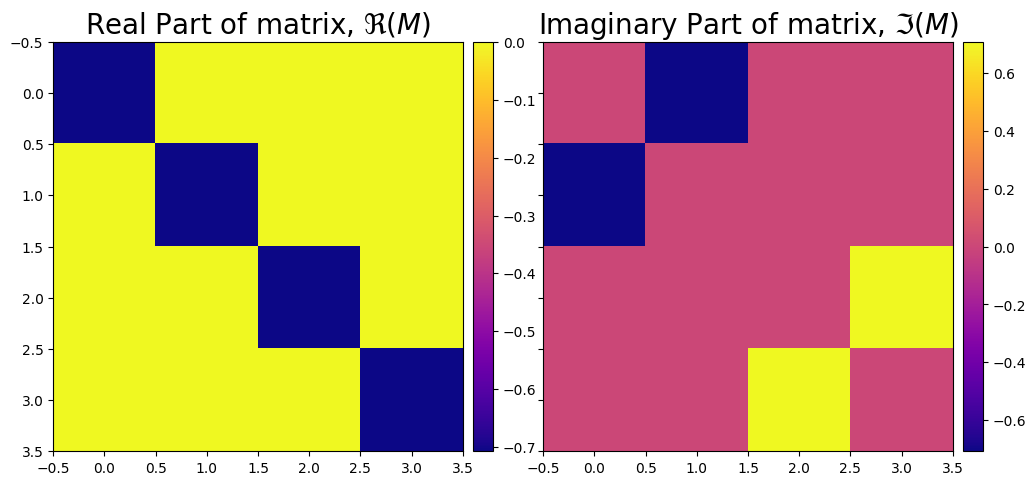

In [227]:
heatmap2d(condense(Transmon_System.ideal_ecr()))

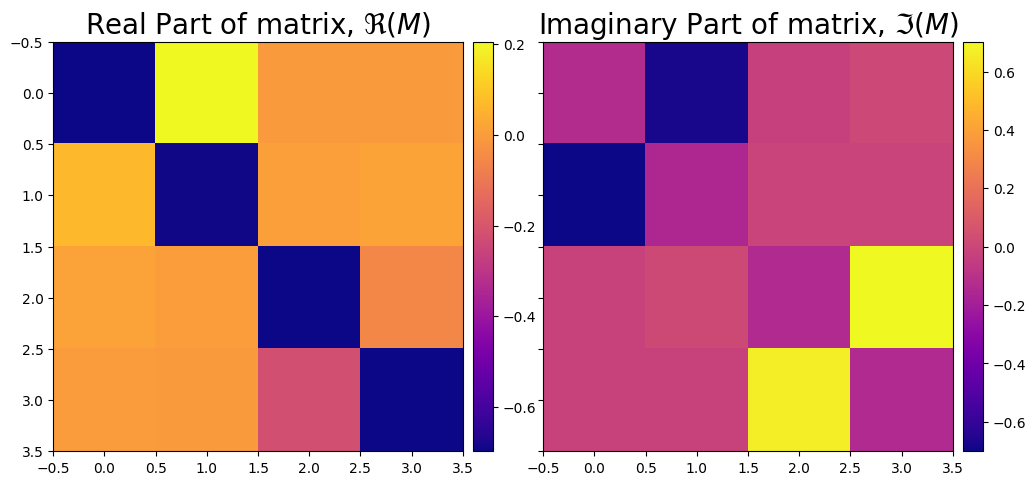

In [228]:
heatmap2d(Transmon_System.project(1j*ecr_gate))

X Gate on Qubit 1 demonstration

Text(0.5, 1.0, 'X Gate on q1, F = 0.9981')

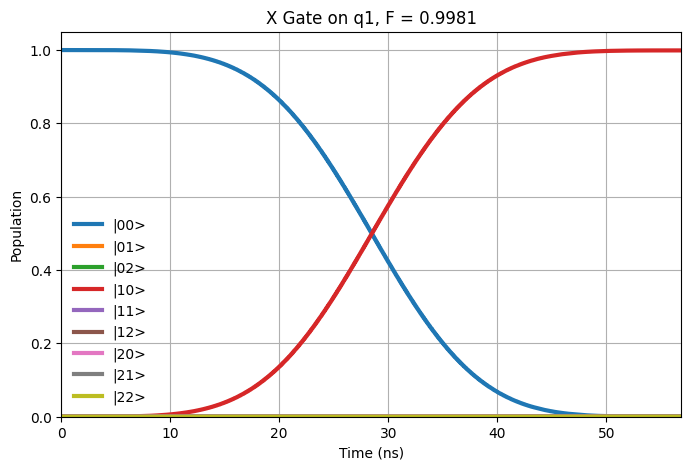

In [225]:
with pulse.build() as XI_pulse: pulse.play(system.q1.X_pulse, channel=pulse.DriveChannel(0))
X_q1_sol00 = system.X_solver.solve(t_span=[0,system.q1.dur*system.dt], y0=Statevector([1.0,0,0,0,0,0,0,0,0]), signals=XI_pulse, atol=1e-8, rtol=1e-8)
Transmon_System.plot_two_qubit_populations(sol=X_q1_sol00, max_t=system.q1.dur*system.dt)
plt.title('X Gate on q1, F = 0.9981')

In [226]:
Transmon_System.fidelity(Transmon_System.ideal_RXI(np.pi), system.XI).item()

0.9981821991987173

CNOT Gate from ECR Gate

In [230]:
ideal_cnot = Transmon_System.ideal_IRX(np.pi/2) @ Transmon_System.ideal_RZI(np.pi/2) @ Transmon_System.ideal_ecr()
cnot_full_unitary = Transmon_System.ideal_RZI(np.pi/2) @ system.ISX @ ecr_gate
Transmon_System.fidelity(ideal_cnot, cnot_full_unitary).item()

0.9921908466750585

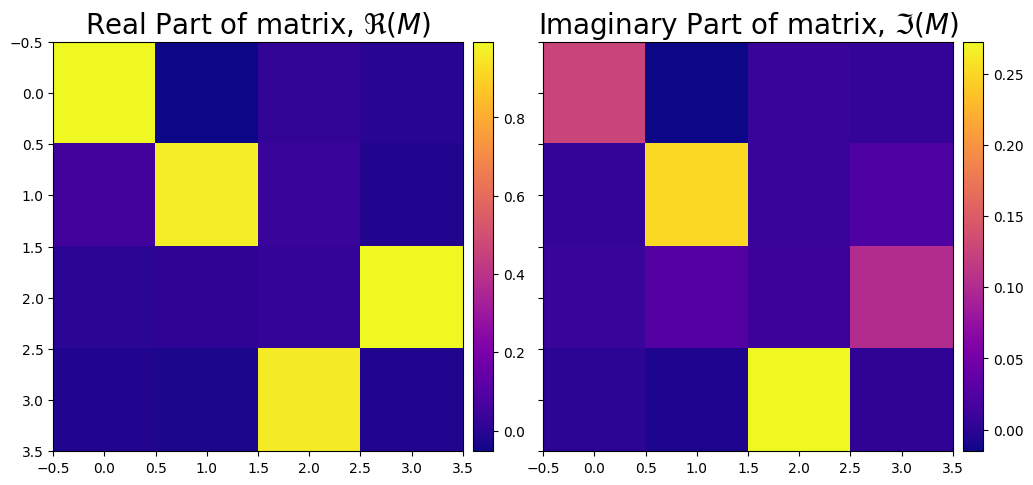

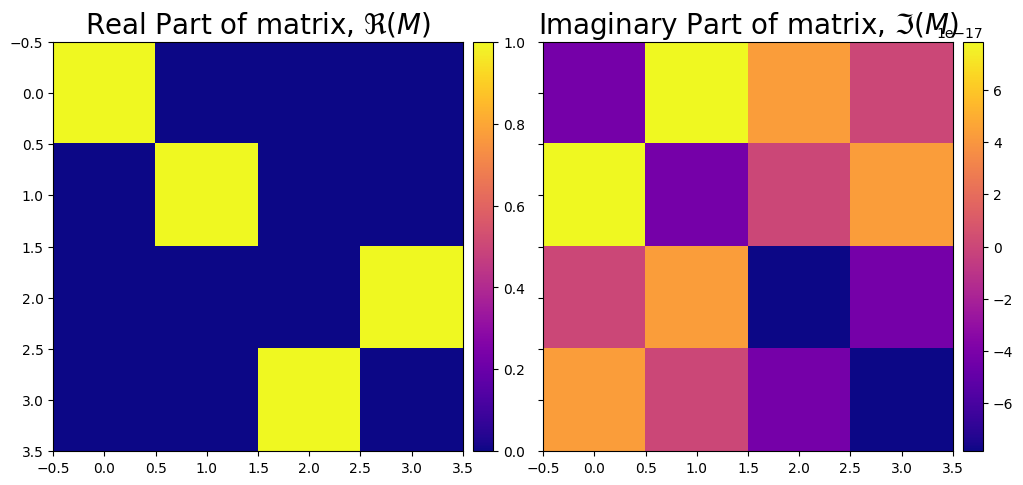

In [236]:
heatmap2d((1/np.sqrt(2))*(1-1j)*condense(cnot_full_unitary))
heatmap2d((1/np.sqrt(2))*(-1-1j)*condense(ideal_cnot))